
ADF Test for adult_icu_crci_patients: p-value = 0.4529

ADF Test for adult_icu_crci_patients: p-value = 0.0077

ADF Test for available_adult_icu_beds: p-value = 0.0157

ADF Test for ped_icu_crci_patients: p-value = 0.0004

ADF Test for available_ped_icu_beds: p-value = 0.5052

ADF Test for available_ped_icu_beds: p-value = 0.0000

🔍 Model Evaluation (on test data):

Target: adult_icu_crci_patients
  MAE: 7.3581
  MSE: 85.6338

Target: available_adult_icu_beds
  MAE: 25.9417
  MSE: 839.6433

Target: ped_icu_crci_patients
  MAE: 1.4430
  MSE: 2.4076

Target: available_ped_icu_beds
  MAE: 4.2718
  MSE: 23.3201

✅ New forecast file saved: icu_forecast_with_future_restored.csv


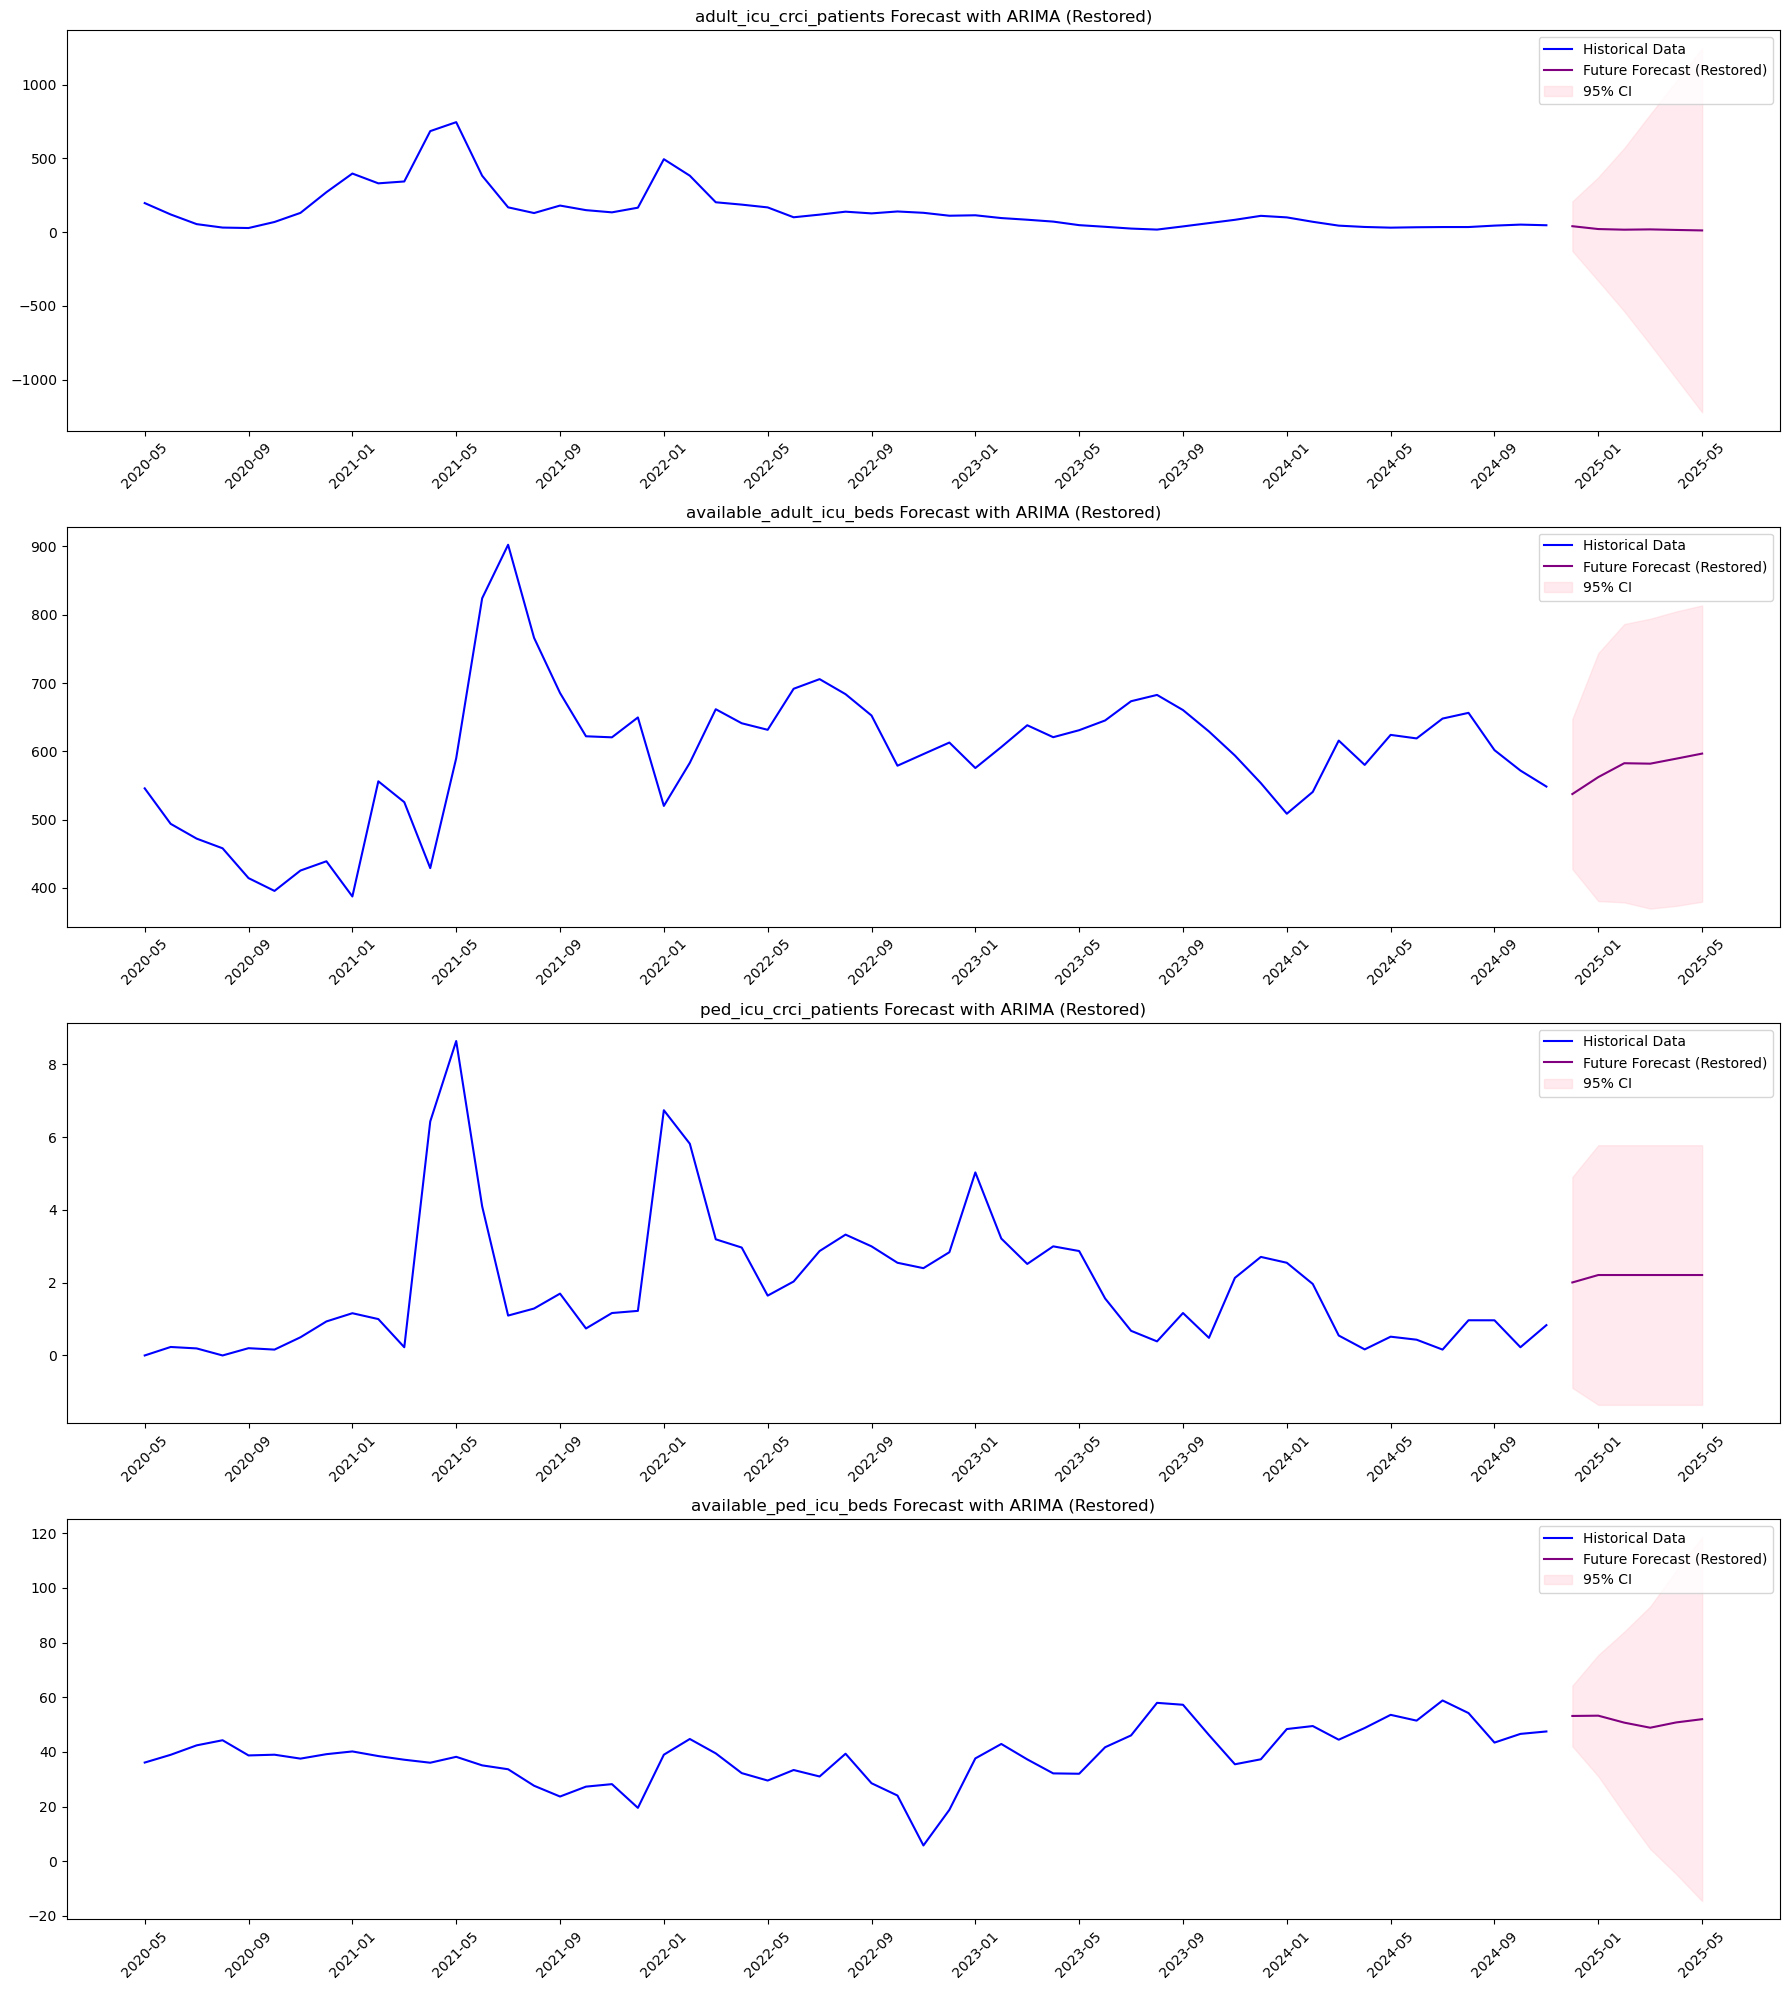

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Data upload
df = pd.read_csv('Availability of adult and pediatric ICU beds and occupancy for COVID-related critical illness.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 2. Data cleaning
df = df.drop(['_id', 'total_adult_icu_beds', 'total_ped_icu_beds'], axis=1)
df['year_month'] = df['date'].dt.to_period('M')

# 3. Monthly aggregation
monthly_data = df.groupby('year_month').agg({
    'adult_icu_crci_patients': 'mean',
    'available_adult_icu_beds': 'mean',
    'ped_icu_crci_patients': 'mean',
    'available_ped_icu_beds': 'mean'
}).reset_index()

# 4. ADF Test
def adf_test(series, name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f'\nADF Test for {name}: p-value = {p_value:.4f}')
    return p_value <= 0.05

# 5. Make data stationary
def make_stationary(df, targets):
    diff_data = df.copy()
    diff_columns = {}
    
    for target in targets:
        series = df[target]
        diff_count = 0
        while not adf_test(series, target) and diff_count < 2:
            diff_count += 1
            series = series.diff().dropna()

        if diff_count > 0:
            diff_col_name = f"{target}_diff{diff_count}"
            diff_data[diff_col_name] = df[target].diff(periods=diff_count)
            diff_columns[target] = (diff_col_name, diff_count)
        else:
            diff_columns[target] = (target, 0)

    diff_data = diff_data.dropna(subset=[col[0] for col in diff_columns.values()])
    return diff_data, diff_columns

targets = ['adult_icu_crci_patients', 'available_adult_icu_beds', 
           'ped_icu_crci_patients', 'available_ped_icu_beds']

diff_data, diff_columns = make_stationary(monthly_data, targets)

# 6. Train-test split
train_data, test_data = train_test_split(diff_data, test_size=0.2, shuffle=False)

# 7. Forecasting and evaluation
forecast_months = 6
forecasts = {}
conf_intervals = {}

print("\n Model Evaluation (on test data):")
for target, (diff_col, diff_count) in diff_columns.items():
    train_series = train_data[diff_col].values
    test_series = test_data[diff_col].values
    
    model = auto_arima(train_series, seasonal=True, m=12,
                       start_p=0, start_q=0, max_p=5, max_q=5,
                       d=0, trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(train_series)

    # Evaluate on test data first
    test_forecast, _ = model.predict(n_periods=len(test_series), return_conf_int=True)
    mae = mean_absolute_error(test_series, test_forecast)
    mse = mean_squared_error(test_series, test_forecast)

    print(f"\nTarget: {target}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")

    # Future forecast
    forecast, conf_int = model.predict(n_periods=forecast_months, return_conf_int=True)

    # Restore differenced values
    if diff_count > 0:
        last_value = monthly_data[target].iloc[-1]
        forecast = np.r_[last_value, forecast].cumsum()[1:]
        conf_int[:, 0] = np.r_[last_value, conf_int[:, 0]].cumsum()[1:]
        conf_int[:, 1] = np.r_[last_value, conf_int[:, 1]].cumsum()[1:]

    forecasts[target] = forecast
    conf_intervals[target] = conf_int

# 8. Create future dates and combine with historical data
last_date = monthly_data['year_month'].iloc[-1]
future_dates = [last_date + i for i in range(1, forecast_months + 1)]

future_df = pd.DataFrame({'year_month': future_dates})
for target in targets:
    future_df[target] = forecasts[target]

combined_df = pd.concat([monthly_data, future_df], ignore_index=True)

# 9. Save to CSV
output_filename = 'icu_forecast_with_future_restored.csv'
combined_df.to_csv(output_filename, index=False)
print(f"\n New forecast file saved: {output_filename}")

# 10. Visualization
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 20))

for i, target in enumerate(targets):
    ax = axes[i]
    ax.plot(monthly_data['year_month'].astype(str), 
            monthly_data[target], label='Historical Data', color='blue')
    ax.plot(future_df['year_month'].astype(str), 
            future_df[target], label='Future Forecast (Restored)', color='purple')
    ax.fill_between(future_df['year_month'].astype(str), 
                    conf_intervals[target][:, 0], 
                    conf_intervals[target][:, 1], 
                    color='pink', alpha=0.3, label='95% CI')
    ax.set_title(f'{target} Forecast with ARIMA (Restored)')
    ax.set_xticks(ax.get_xticks()[::4])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()